In [13]:
import os
import sys
import lightgbm as lgb
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Setup paths
NOTEBOOK_DIR = os.getcwd()  # data_analysis
PROJ_DIR = os.path.dirname(NOTEBOOK_DIR)  # main project folder
MODEL_DIR = os.path.join(PROJ_DIR, "trained_models")
DATA_DIR = os.path.join(PROJ_DIR, "feature_enhanced_data/null_flags_and_forward_fill.parquet")

# Add training source to path for imports
sys.path.append(os.path.join(PROJ_DIR, "training"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src", "utils"))

# Import our utility functions
from src.data_loading import DataLoader
from src.utils.metrics import r2_score_weighted

In [14]:
# Configuration
SEGMENT_LENGTH = 1  # Length of validation segments

# Define models and their training days
MODELS = [
    # Forward-trained models (starting from beginning)
    {"name": "first_250.txt", "train_start": 0, "train_end": 250},
    {"name": "first_500.txt", "train_start": 0, "train_end": 500},
    {"name": "first_750.txt", "train_start": 0, "train_end": 750},
    {"name": "first_1000.txt", "train_start": 0, "train_end": 1000},
    {"name": "first_1250.txt", "train_start": 0, "train_end": 1250},
    {"name": "first_1500.txt", "train_start": 0, "train_end": 1500},
    
    # Backward-trained models (ending at 1698)
    {"name": "last_250.txt", "train_start": 1448, "train_end": 1698},
    {"name": "last_500.txt", "train_start": 1198, "train_end": 1698},
    {"name": "last_750.txt", "train_start": 948, "train_end": 1698},
    {"name": "last_1000.txt", "train_start": 698, "train_end": 1698},
    {"name": "last_1250.txt", "train_start": 448, "train_end": 1698},
    {"name": "last_1500.txt", "train_start": 198, "train_end": 1698}
]

# Print training ranges for clarity
print("Training Ranges:")
print("-" * 50)
for model in MODELS:
    print(f"{model['name']:<15}: Days {model['train_start']:>4} to {model['train_end']:<4} "
          f"({model['train_end'] - model['train_start']} days)")

Training Ranges:
--------------------------------------------------
first_250.txt  : Days    0 to 250  (250 days)
first_500.txt  : Days    0 to 500  (500 days)
first_750.txt  : Days    0 to 750  (750 days)
first_1000.txt : Days    0 to 1000 (1000 days)
first_1250.txt : Days    0 to 1250 (1250 days)
first_1500.txt : Days    0 to 1500 (1500 days)
last_250.txt   : Days 1448 to 1698 (250 days)
last_500.txt   : Days 1198 to 1698 (500 days)
last_750.txt   : Days  948 to 1698 (750 days)
last_1000.txt  : Days  698 to 1698 (1000 days)
last_1250.txt  : Days  448 to 1698 (1250 days)
last_1500.txt  : Days  198 to 1698 (1500 days)


In [15]:
def load_model(model_path: str) -> lgb.Booster:
    """Load the LightGBM model"""
    return lgb.Booster(model_file=model_path)

In [16]:
def create_validation_segments(df: pl.DataFrame, models: list, segment_length: int) -> dict:
    """Create list of validation segments for each model"""
    segments_by_model = {}
    
    for model in models:
        model_name = model['name']
        is_forward = model_name.startswith('first')
        
        # For forward models, evaluate after train_end
        # For backward models, evaluate before train_start
        if is_forward:
            all_days = (df.select('date_id')
                        .unique()
                        .filter(pl.col('date_id') > model['train_end'])
                        .sort('date_id')
                        .get_column('date_id')
                        .to_list())
        else:
            all_days = (df.select('date_id')
                        .unique()
                        .filter(pl.col('date_id') < model['train_start'])
                        .sort('date_id')
                        .get_column('date_id')
                        .to_list())
        
        segments = []
        for i in range(0, len(all_days) - segment_length + 1, segment_length):
            segment_days = all_days[i:i + segment_length]
            segments.append({
                'start_day': segment_days[0],
                'end_day': segment_days[-1],
                'days': segment_days,
                'is_forward': is_forward
            })
        
        print(f"\nFor model {model_name}:")
        print(f"Created segments from {len(all_days)} unique days")
        if segments:
            print(f"First segment: Days {segments[0]['start_day']} to {segments[0]['end_day']}")
            print(f"Last segment: Days {segments[-1]['start_day']} to {segments[-1]['end_day']}")
        
        segments_by_model[model_name] = segments
    
    return segments_by_model

In [17]:
def evaluate_segment(models: dict, df: pl.DataFrame, segment: dict, exclude_cols: list) -> dict:
    """Evaluate appropriate models on a specific segment"""
    # Filter data for segment
    segment_mask = pl.col('date_id').is_in(segment['days'])
    segment_data = df.filter(segment_mask)

    # Get features (everything not in exclude_cols)
    X = segment_data.select([
        col for col in segment_data.columns 
        if col not in exclude_cols + ['responder_6']
    ]).to_numpy()

    y_true = segment_data.select('responder_6').to_numpy().ravel()
    weights = segment_data.select('weight').to_numpy().ravel()

    # Base results dictionary
    results = {
        'start_day': segment['start_day'],
        'end_day': segment['end_day'],
        'n_samples': len(y_true),
        'mean_weight': weights.mean(),
        'std_weight': weights.std(),
        'is_forward': segment['is_forward']
    }

    # Calculate metrics for all models
    for model_name, model in models.items():
        y_pred = model.predict(X)
        r2 = r2_score_weighted(y_true, y_pred, weights)
        results[f'r2_score_{model_name}'] = r2

    # Add direction to help with analysis
    results['segment_type'] = 'forward' if segment['is_forward'] else 'backward'

    return results

In [18]:
# Load data using DataLoader
print("Loading data...")
data_loader = DataLoader(DATA_DIR)
train = pl.scan_parquet(DATA_DIR).select(
    pl.int_range(pl.len(), dtype=pl.UInt64).alias("id") if 'id' not in pl.scan_parquet(data_loader.data_path).columns else pl.col("id"),
    pl.all().exclude("id"),
)   

# Get feature columns and exclude columns
feature_cols, exclude_cols = data_loader.get_feature_columns(train)

# Collect to DataFrame but stay in Polars
print("Collecting DataFrame...")
df = train.collect(parallel=True)
print(f"Loaded DataFrame shape: {df.shape}")

print("Loading models...")
models = {}
for model_config in MODELS:
    model_name = model_config['name']
    print(f"Loading {model_name}...")
    models[model_name] = load_model(os.path.join(MODEL_DIR, model_name))

# Create validation segments for each model
print("\nCreating validation segments...")
segments_by_model = create_validation_segments(df, MODELS, SEGMENT_LENGTH)

# Evaluate each segment for each model
print("\nEvaluating segments...")
results = []

# Process all segments from all models
all_segments = []
for model_segments in segments_by_model.values():
    all_segments.extend(model_segments)

# Sort segments by start_day for progress tracking
all_segments.sort(key=lambda x: x['start_day'])

# Evaluate each unique segment
processed_days = set()
for segment in tqdm(all_segments, desc="Evaluating segments"):
    # Skip if we've already processed this day
    if segment['start_day'] in processed_days:
        continue
    
    processed_days.add(segment['start_day'])
    
    # Evaluate all models on this segment
    segment_result = evaluate_segment(models, df, segment, exclude_cols)
    results.append(segment_result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Add day distance columns for analysis
for model_config in MODELS:
    model_name = model_config['name']
    if model_name.startswith('first'):
        results_df[f'days_after_{model_name}'] = results_df['start_day'] - model_config['train_end']
    else:
        results_df[f'days_before_{model_name}'] = model_config['train_start'] - results_df['start_day']

# Print summary statistics
print("\nResults Summary:")
print(f"Total segments evaluated: {len(results_df)}")
print(f"Forward predictions: {len(results_df[results_df['segment_type'] == 'forward'])}")
print(f"Backward predictions: {len(results_df[results_df['segment_type'] == 'backward'])}")

# Optional: Split results into forward and backward for separate analysis
forward_results = results_df[results_df['segment_type'] == 'forward']
backward_results = results_df[results_df['segment_type'] == 'backward']

Loading data...

📊 Analyzing column structure...
Found 158 features and 12 columns to exclude


/tmp/ipykernel_4190928/2817169844.py:5: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  pl.int_range(pl.len(), dtype=pl.UInt64).alias("id") if 'id' not in pl.scan_parquet(data_loader.data_path).columns else pl.col("id"),


Loaded DataFrame shape: (47127338, 173)
Loading models...
Loading first_250.txt...
Loading first_500.txt...
Loading first_750.txt...
Loading first_1000.txt...
Loading first_1250.txt...
Loading first_1500.txt...
Loading last_250.txt...
Loading last_500.txt...
Loading last_750.txt...
Loading last_1000.txt...
Loading last_1250.txt...
Loading last_1500.txt...

Creating validation segments...

For model first_250.txt:
Created segments from 1448 unique days
First segment: Days 251 to 251
Last segment: Days 1698 to 1698

For model first_500.txt:
Created segments from 1198 unique days
First segment: Days 501 to 501
Last segment: Days 1698 to 1698

For model first_750.txt:
Created segments from 948 unique days
First segment: Days 751 to 751
Last segment: Days 1698 to 1698

For model first_1000.txt:
Created segments from 698 unique days
First segment: Days 1001 to 1001
Last segment: Days 1698 to 1698

For model first_1250.txt:
Created segments from 448 unique days
First segment: Days 1251 to 125

Evaluating segments: 100%|██████████| 9876/9876 [24:31<00:00,  6.71it/s]



Results Summary:
Total segments evaluated: 1699
Forward predictions: 1448
Backward predictions: 251


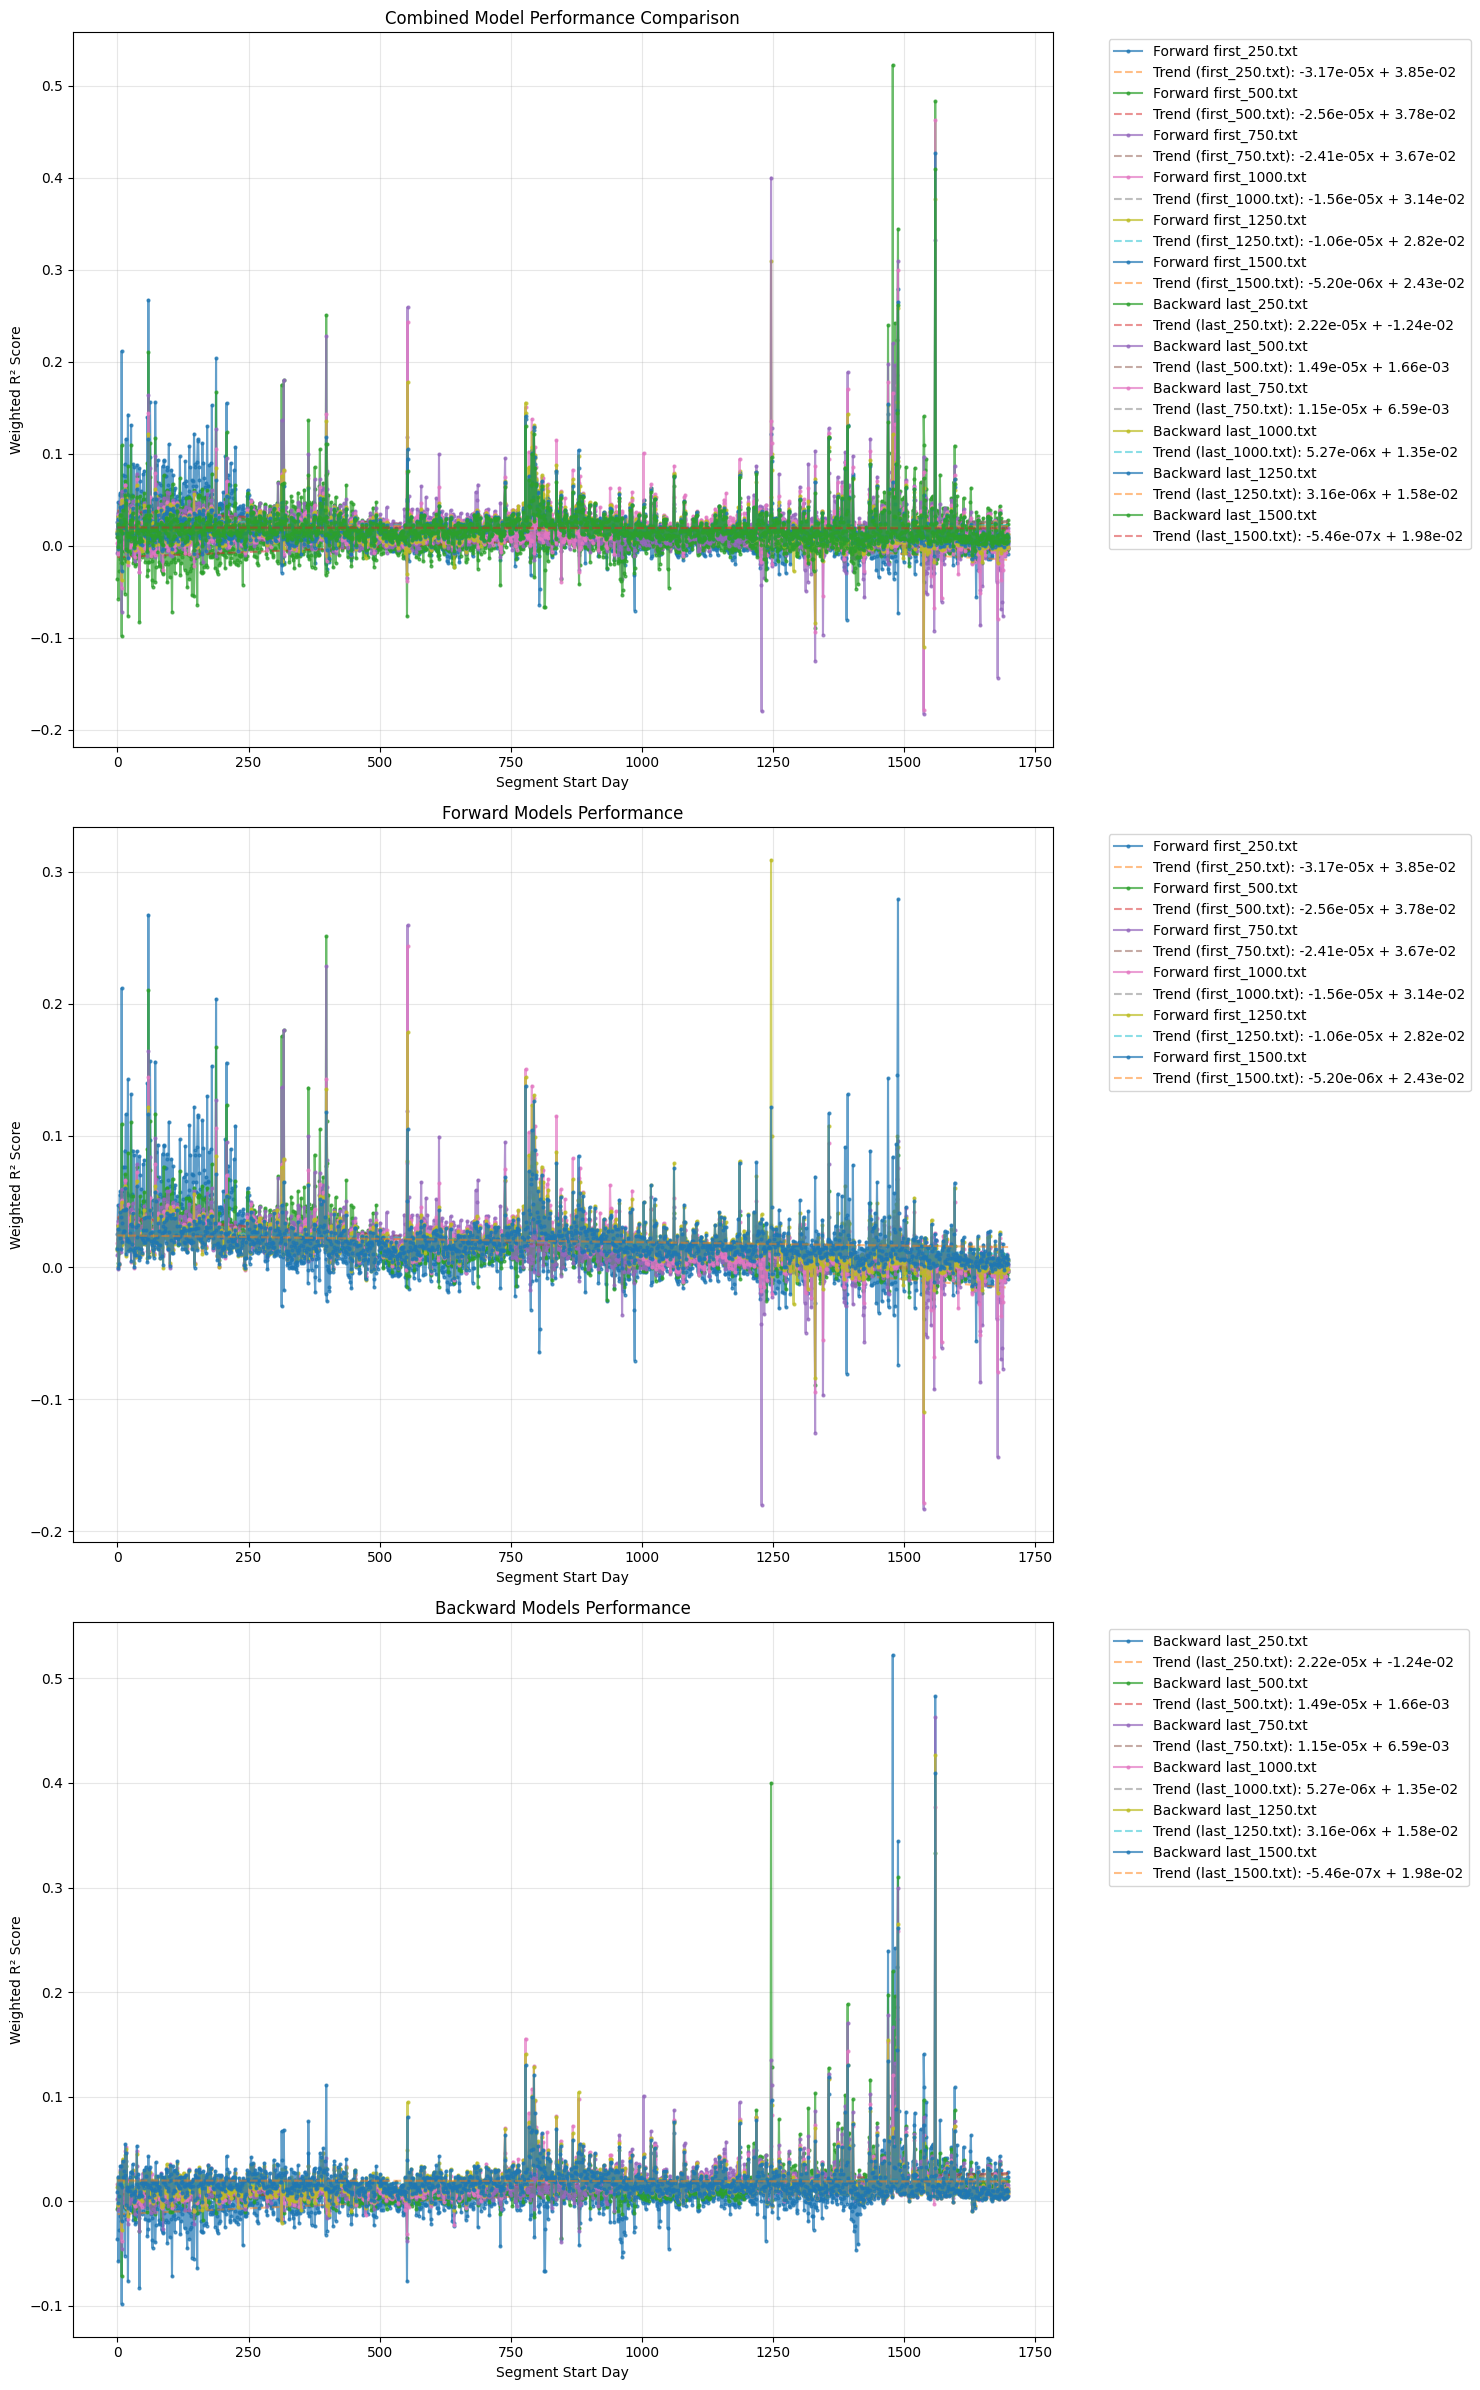

In [19]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 24))

# 1. Combined Plot
for model_config in MODELS:
    model_name = model_config['name']
    r2_col = f'r2_score_{model_name}'
    is_forward = model_name.startswith('first')
    
    valid_results = results_df[['start_day', r2_col]].dropna()
    
    # Plot scores
    ax1.plot(valid_results['start_day'], valid_results[r2_col], 
            marker='o', markersize=2,
            label=f'{"Forward" if is_forward else "Backward"} {model_name}', alpha=0.7)
    
    # Add trend line
    z = np.polyfit(valid_results['start_day'], valid_results[r2_col], 1)
    p = np.poly1d(z)
    ax1.plot(valid_results['start_day'], p(valid_results['start_day']), 
             "--", alpha=0.5,
             label=f'Trend ({model_name}): {z[0]:.2e}x + {z[1]:.2e}')

ax1.set_title('Combined Model Performance Comparison')
ax1.set_xlabel('Segment Start Day')
ax1.set_ylabel('Weighted R² Score')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Forward Models Plot
for model_config in [m for m in MODELS if m['name'].startswith('first')]:
    model_name = model_config['name']
    r2_col = f'r2_score_{model_name}'
    
    valid_results = results_df[['start_day', r2_col]].dropna()
    
    # Plot scores
    ax2.plot(valid_results['start_day'], valid_results[r2_col], 
            marker='o', markersize=2,
            label=f'Forward {model_name}', alpha=0.7)
    
    # Add trend line
    z = np.polyfit(valid_results['start_day'], valid_results[r2_col], 1)
    p = np.poly1d(z)
    ax2.plot(valid_results['start_day'], p(valid_results['start_day']), 
             "--", alpha=0.5,
             label=f'Trend ({model_name}): {z[0]:.2e}x + {z[1]:.2e}')

ax2.set_title('Forward Models Performance')
ax2.set_xlabel('Segment Start Day')
ax2.set_ylabel('Weighted R² Score')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Backward Models Plot
for model_config in [m for m in MODELS if m['name'].startswith('last')]:
    model_name = model_config['name']
    r2_col = f'r2_score_{model_name}'
    
    valid_results = results_df[['start_day', r2_col]].dropna()
    
    # Plot scores
    ax3.plot(valid_results['start_day'], valid_results[r2_col], 
            marker='o', markersize=2,
            label=f'Backward {model_name}', alpha=0.7)
    
    # Add trend line
    z = np.polyfit(valid_results['start_day'], valid_results[r2_col], 1)
    p = np.poly1d(z)
    ax3.plot(valid_results['start_day'], p(valid_results['start_day']), 
             "--", alpha=0.5,
             label=f'Trend ({model_name}): {z[0]:.2e}x + {z[1]:.2e}')

ax3.set_title('Backward Models Performance')
ax3.set_xlabel('Segment Start Day')
ax3.set_ylabel('Weighted R² Score')
ax3.grid(True, alpha=0.3)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
def analyze_sequential_decay(results_df, models, max_days_out=50, bin_size=100, zscore_threshold=3):
    # Create decay data structure
    decay_data = []
    
    # For each model, clean its data independently
    for model_config in models:
        model_name = model_config['name']
        train_end = model_config['train_end']
        r2_col = f'r2_score_{model_name}'
        
        # Get valid results for this model
        model_results = results_df[['start_day', r2_col]].dropna()
        
        # Remove outliers from raw R² scores for this model
        r2_scores = model_results[r2_col]
        z_scores = np.abs((r2_scores - r2_scores.mean()) / r2_scores.std())
        clean_results = model_results[z_scores < zscore_threshold]
        
        # Calculate days from training for cleaned results
        model_decay = clean_results.assign(
            days_from_training=clean_results['start_day'] - train_end,
            time_bin=(clean_results['start_day'] - train_end) // bin_size,
            model=model_name,
            train_end=train_end,
            r2_score=clean_results[r2_col]
        )
        
        print(f"\nModel {model_name}:")
        print(f"Original points: {len(model_results)}")
        print(f"After cleaning: {len(clean_results)}")
        print(f"Removed: {len(model_results) - len(clean_results)} ({(1 - len(clean_results)/len(model_results))*100:.1f}%)")
        
        decay_data.append(model_decay)
    
    # Combine all models' cleaned decay data
    decay_df = pd.concat(decay_data, ignore_index=True)
    
    # Filter to only look at max_days_out
    early_decay = decay_df[decay_df['days_from_training'] <= max_days_out]
    
    # Calculate statistics on cleaned data
    overall_decay = early_decay.groupby('days_from_training')['r2_score'].agg([
        'mean', 'std', 'count'
    ]).reset_index()
    
    binned_decay = early_decay.groupby(['time_bin', 'days_from_training'])['r2_score'].agg([
        'mean', 'std', 'count'
    ]).reset_index()
    
    # Plotting
    plt.figure(figsize=(20, 15))
    
    # Plot 1: Raw R² distributions for each model
    plt.subplot(2, 2, 1)
    plt.boxplot([
        results_df[f'r2_score_{model["name"]}'].dropna() 
        for model in models
    ], labels=[f"Model {model['train_end']}" for model in models])
    plt.title('Raw R² Score Distributions by Model')
    plt.xticks(rotation=45)
    plt.ylabel('R² Score')
    
    # Plot 2: Overall decay pattern (cleaned)
    plt.subplot(2, 2, 2)
    plt.errorbar(overall_decay['days_from_training'], 
                overall_decay['mean'],
                yerr=1.96 * overall_decay['std'] / np.sqrt(overall_decay['count']),
                label='Mean R² with 95% CI',
                alpha=0.7)
    
    # Add trend line
    z = np.polyfit(overall_decay['days_from_training'], overall_decay['mean'], 1)
    p = np.poly1d(z)
    plt.plot(overall_decay['days_from_training'], 
             p(overall_decay['days_from_training']), 
             "r--", label=f'Linear trend: {z[0]:.2e}x + {z[1]:.2e}')
    
    plt.title(f'Average R² Decay Pattern (Cleaned)')
    plt.xlabel('Days from Training End')
    plt.ylabel('Mean R² Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 3: Decay patterns by time bin (cleaned)
    plt.subplot(2, 2, 3)
    for bin_num in binned_decay['time_bin'].unique():
        bin_data = binned_decay[binned_decay['time_bin'] == bin_num]
        bin_start = bin_num * bin_size
        bin_end = (bin_num + 1) * bin_size
        plt.plot(bin_data['days_from_training'], 
                bin_data['mean'],
                label=f'Days {bin_start}-{bin_end}',
                alpha=0.7)
    
    plt.title(f'R² Decay Pattern by Time Period (Cleaned)')
    plt.xlabel('Days from Training End')
    plt.ylabel('Mean R² Score')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 4: Box plot of R² scores by days out
    plt.subplot(2, 2, 4)
    data_to_plot = []
    labels = []
    for i in range(min(10, max_days_out)):  # First 10 days
        data_to_plot.append(early_decay[early_decay['days_from_training'] == i]['r2_score'])
        labels.append(f'Day {i}')
    
    plt.boxplot(data_to_plot, labels=labels)
    plt.title('Distribution of R² Scores by Day (First 10 Days)')
    plt.ylabel('R² Score')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print decay statistics
    print("\nDecay Factors (Cleaned Data):")
    for i in range(1, min(6, len(overall_decay))):
        day_decay = (overall_decay.iloc[i]['mean'] - overall_decay.iloc[i-1]['mean']) / overall_decay.iloc[i-1]['mean']
        print(f"Day {i} to {i+1}: {day_decay:.4%} change")
    
    # Calculate stability of decay pattern across time bins
    print("\nDecay Pattern Stability (Cleaned Data):")
    for i in range(1, 10):  # First 5 days
        day_decays = []
        for bin_num in binned_decay['time_bin'].unique():
            bin_data = binned_decay[binned_decay['time_bin'] == bin_num]
            if len(bin_data) > i:
                day_decay = (bin_data.iloc[i]['mean'] - bin_data.iloc[i-1]['mean']) / bin_data.iloc[i-1]['mean']
                day_decays.append(day_decay)
        
        if day_decays:
            print(f"Day {i} to {i+1}:")
            print(f"  Mean decay: {np.mean(day_decays):.4%}")
            print(f"  Std dev: {np.std(day_decays):.4%}")
    
    # Replace the previous print statements with our new detailed analysis
    print_detailed_statistics(overall_decay, binned_decay, decay_df)
    
    return overall_decay, binned_decay, decay_df

In [21]:
def print_detailed_statistics(overall_decay, binned_decay, decay_df, n_days=20):
    print("\n=== DETAILED DECAY ANALYSIS ===")
    
    # Overall statistics
    print("\n1. OVERALL STATISTICS FOR FIRST", n_days, "DAYS")
    print("-" * 50)
    for i in range(n_days):
        day_data = overall_decay[overall_decay['days_from_training'] == i]
        if not day_data.empty:
            print(f"\nDay {i}:")
            print(f"  Mean R²: {day_data['mean'].iloc[0]:.6f}")
            print(f"  Std:    {day_data['std'].iloc[0]:.6f}")
            print(f"  Count:  {day_data['count'].iloc[0]}")
            if i > 0:
                prev_day = overall_decay[overall_decay['days_from_training'] == (i-1)]['mean'].iloc[0]
                curr_day = day_data['mean'].iloc[0]
                change = (curr_day - prev_day) / prev_day
                print(f"  Change from previous day: {change:.4%}")

    # Bin-by-Bin Analysis
    print("\n2. BIN-BY-BIN ANALYSIS")
    print("-" * 50)
    for bin_num in sorted(binned_decay['time_bin'].unique()):
        bin_data = binned_decay[binned_decay['time_bin'] == bin_num]
        bin_start = bin_num * bin_size
        bin_end = (bin_num + 1) * bin_size
        
        print(f"\nBin {bin_num} (Days {bin_start}-{bin_end}):")
        for i in range(min(n_days, len(bin_data))):
            day_data = bin_data[bin_data['days_from_training'] == i]
            if not day_data.empty:
                print(f"  Day {i}:")
                print(f"    Mean R²: {day_data['mean'].iloc[0]:.6f}")
                print(f"    Std:    {day_data['std'].iloc[0]:.6f}")
                print(f"    Count:  {day_data['count'].iloc[0]}")

    # Stability Analysis
    print("\n3. DECAY STABILITY ANALYSIS")
    print("-" * 50)
    for i in range(1, n_days):
        day_decays = []
        for bin_num in binned_decay['time_bin'].unique():
            bin_data = binned_decay[binned_decay['time_bin'] == bin_num]
            if len(bin_data) > i:
                prev_day = bin_data[bin_data['days_from_training'] == (i-1)]['mean'].iloc[0]
                curr_day = bin_data[bin_data['days_from_training'] == i]['mean'].iloc[0]
                day_decay = (curr_day - prev_day) / prev_day
                day_decays.append(day_decay)
        
        if day_decays:
            print(f"\nDay {i-1} to {i}:")
            print(f"  Mean decay:    {np.mean(day_decays):.4%}")
            print(f"  Median decay:  {np.median(day_decays):.4%}")
            print(f"  Std dev:       {np.std(day_decays):.4%}")
            print(f"  Min decay:     {np.min(day_decays):.4%}")
            print(f"  Max decay:     {np.max(day_decays):.4%}")
            print(f"  25th percentile: {np.percentile(day_decays, 25):.4%}")
            print(f"  75th percentile: {np.percentile(day_decays, 75):.4%}")
            print(f"  Samples:       {len(day_decays)}")

    # Distribution Analysis
    print("\n4. R² SCORE DISTRIBUTION BY DAY")
    print("-" * 50)
    for i in range(n_days):
        day_scores = decay_df[decay_df['days_from_training'] == i]['r2_score']
        if not day_scores.empty:
            print(f"\nDay {i} Distribution:")
            print(f"  Mean:    {day_scores.mean():.6f}")
            print(f"  Median:  {day_scores.median():.6f}")
            print(f"  Std:     {day_scores.std():.6f}")
            print(f"  Skew:    {day_scores.skew():.6f}")
            print(f"  Kurtosis:{day_scores.kurtosis():.6f}")
            print(f"  5th percentile:  {day_scores.quantile(0.05):.6f}")
            print(f"  95th percentile: {day_scores.quantile(0.95):.6f}")
            print(f"  Samples: {len(day_scores)}")


Model first_250.txt:
Original points: 1699
After cleaning: 1426
Removed: 273 (16.1%)

Model first_500.txt:
Original points: 1699
After cleaning: 1383
Removed: 316 (18.6%)

Model first_750.txt:
Original points: 1699
After cleaning: 1468
Removed: 231 (13.6%)

Model first_1000.txt:
Original points: 1699
After cleaning: 1435
Removed: 264 (15.5%)

Model first_1250.txt:
Original points: 1699
After cleaning: 1438
Removed: 261 (15.4%)

Model first_1500.txt:
Original points: 1699
After cleaning: 1449
Removed: 250 (14.7%)

Model last_250.txt:
Original points: 1699
After cleaning: 1534
Removed: 165 (9.7%)

Model last_500.txt:
Original points: 1699
After cleaning: 1580
Removed: 119 (7.0%)

Model last_750.txt:
Original points: 1699
After cleaning: 1560
Removed: 139 (8.2%)

Model last_1000.txt:
Original points: 1699
After cleaning: 1528
Removed: 171 (10.1%)

Model last_1250.txt:
Original points: 1699
After cleaning: 1545
Removed: 154 (9.1%)

Model last_1500.txt:
Original points: 1699
After cleaning

/tmp/ipykernel_4190928/90913813.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([
/tmp/ipykernel_4190928/90913813.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)


/tmp/ipykernel_4190928/90913813.py:114: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


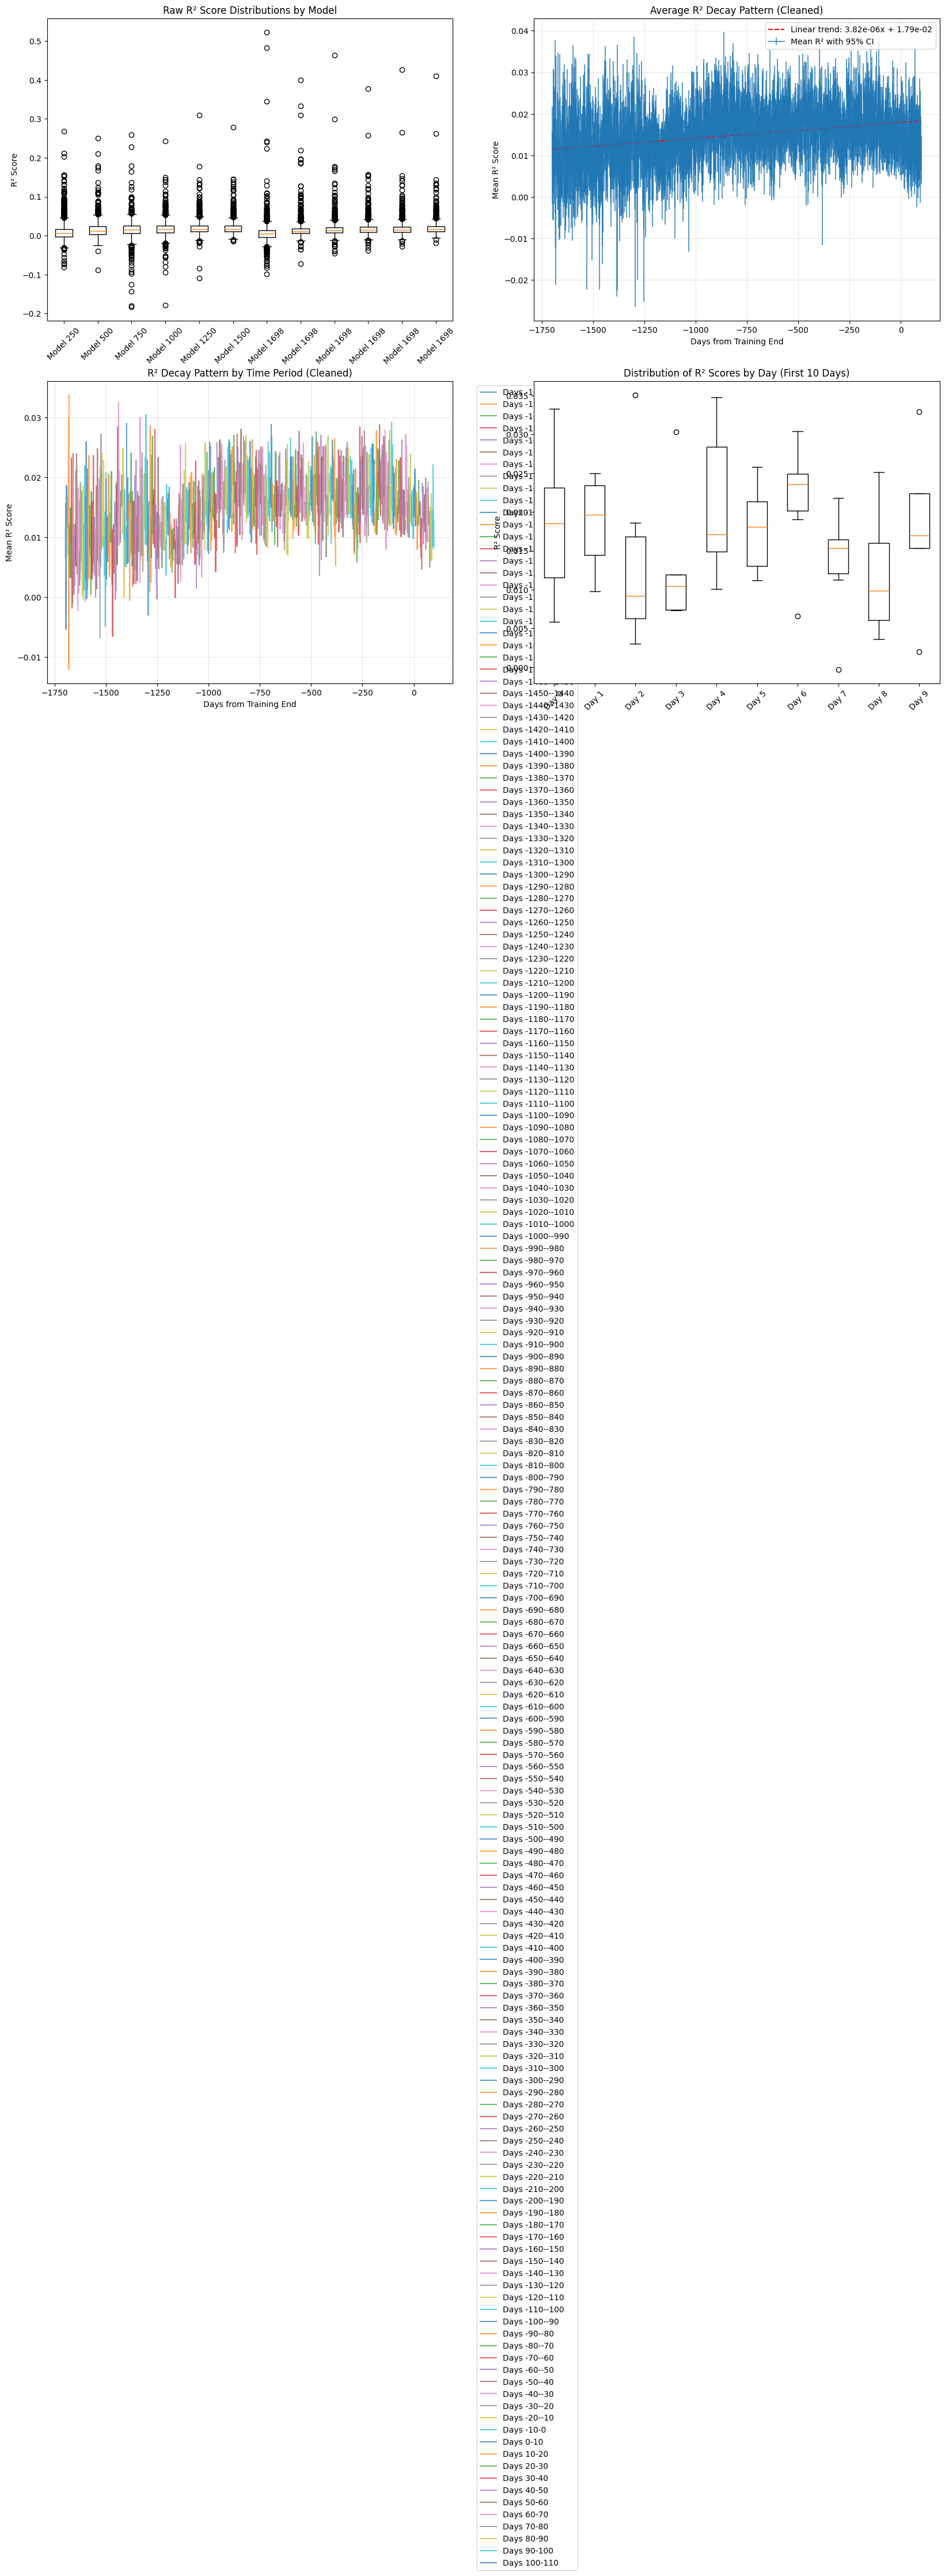


Decay Factors (Cleaned Data):
Day 1 to 2: 135.8357% change
Day 2 to 3: -134.3133% change
Day 3 to 4: -174.1753% change
Day 4 to 5: -30.3704% change
Day 5 to 6: 570.1113% change

Decay Pattern Stability (Cleaned Data):
Day 1 to 2:
  Mean decay: 15.9787%
  Std dev: 76.0143%
Day 2 to 3:
  Mean decay: 10.5127%
  Std dev: 73.6569%
Day 3 to 4:
  Mean decay: 11.0777%
  Std dev: 117.3035%
Day 4 to 5:
  Mean decay: 19.3796%
  Std dev: 110.0959%
Day 5 to 6:
  Mean decay: 60.3010%
  Std dev: 475.9264%
Day 6 to 7:
  Mean decay: -0.9666%
  Std dev: 289.7637%
Day 7 to 8:
  Mean decay: -24.4073%
  Std dev: 695.6729%
Day 8 to 9:
  Mean decay: -108.0816%
  Std dev: 1213.6418%
Day 9 to 10:
  Mean decay: 34.2675%
  Std dev: 212.8982%

=== DETAILED DECAY ANALYSIS ===

1. OVERALL STATISTICS FOR FIRST 20 DAYS
--------------------------------------------------

Day 0:
  Mean R²: 0.017748
  Std:    0.007897
  Count:  11

Day 1:
  Mean R²: 0.018561
  Std:    0.006082
  Count:  6
  Change from previous day: 4.

NameError: name 'bin_size' is not defined

In [22]:
# Run the analysis with new bin size
overall_decay, binned_decay, cleaned_data = analyze_sequential_decay(
    results_df, 
    MODELS,
    max_days_out=100,
    bin_size=10,    # Changed to 10-day bins
    zscore_threshold=1
)